## Gait Video Study
### SHAP-based feature importance for Subject generalization framework in  WT
For local interpretation explanations, see https://www.kdnuggets.com/2019/12/interpretability-part-3-lime-shap.html

For installation, run:
* !pip install --upgrade setuptools
* !conda install -c conda-forge shap

In [1]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import subject_gen_DLtrainer, DLutils, CNN1d_model, gait_data_loader, TCN_model, LSTM_model, GRU_model, RNN_model, MULTISCALE_RESNET_model, RESNET_model
reload(subject_gen_DLtrainer)
reload(DLutils)
reload(CNN1d_model)
reload(TCN_model)
reload(LSTM_model)
reload(GRU_model)
reload(RNN_model)
reload(RESNET_model)
reload(MULTISCALE_RESNET_model)
from ml_utils.DLutils import set_random_seed, accuracy_score_multi_class
from ml_utils.subject_gen_DLtrainer import GaitTrainer
from ml_utils.CNN1d_model import CNN1D
from ml_utils.TCN_model import TCN
from ml_utils.LSTM_model import LSTM
from ml_utils.GRU_model import GRU
from ml_utils.RNN_model import RNN
from ml_utils.MULTISCALE_RESNET_model import MSResNet
from ml_utils.RESNET_model import ResNet
from ml_utils.gait_data_loader import GaitDataset
import shap

In [5]:
#Config path for the best subject gen model containing the "saved_model_path" as the 
#best model's directory and params.pt file and the best model parameters 
config_path = ".\config_files\config_template_subject_genWT_shap_cnn.json"
#Fold for which we are going to use training/validation and trained model for
fold_number = 5

#Set up vars for parsing
hyperparameter_grid = {}
parameter_dict = {}

#Load config
with open(config_path) as f: 
    config_data = f.read()

config = json.loads(config_data)

#Parse through imported dictionary
for key, value in config.items():
    if 'param_' in key:
        pkey = key.replace("param_", "")
        if 'optimizer' in pkey:
            op = []
            for optim_string in value:
                op.append(optims[optim_string])
            hyperparameter_grid[pkey] = op
        else:
            hyperparameter_grid[pkey] = value
    else:
        parameter_dict[key] = value      

In [6]:
use_cuda = torch.cuda.is_available() #use_cuda is True if cuda is available 
set_random_seed(0, use_cuda) #Setting a fixed random seed for reproducibility 
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
if parameter_dict["model"]=="CNN1D":
    in_chans = hyperparameter_grid["net__module__in_chans"][0]
    out_chans = hyperparameter_grid["net__module__out_chans"][0]
    kernel_size = hyperparameter_grid["net__module__kernel_size"][0]
    stride = hyperparameter_grid["net__module__stride"][0]
    dilation = hyperparameter_grid["net__module__dilation"][0]
    groups = hyperparameter_grid["net__module__groups"][0]
    batch_norm = hyperparameter_grid["net__module__batch_norm"][0]
    dropout = hyperparameter_grid["net__module__dropout"][0]
    maxpool = hyperparameter_grid["net__module__maxpool"][0]
    maxpool_kernel_size = hyperparameter_grid["net__module__maxpool_kernel_size"][0]
    dense_out_sizes = hyperparameter_grid["net__module__dense_out_sizes"][0]
    dense_pool = hyperparameter_grid["net__module__dense_pool"][0]
    dense_pool_kernel_size= hyperparameter_grid["net__module__dense_pool_kernel_size"][0]
    dense_dropout = hyperparameter_grid["net__module__dense_dropout"][0]
    global_average_pool = hyperparameter_grid["net__module__global_average_pool"][0]
    num_classes = hyperparameter_grid["net__module__num_classes"][0] 
    time_steps = hyperparameter_grid["net__module__time_steps"][0]
    position_encoding = hyperparameter_grid["net__module__position_encoding"][0]
    model_class_ = CNN1D
    model_ = CNN1D(in_chans, out_chans, kernel_size, stride, dilation, groups, batch_norm, dropout, maxpool, maxpool_kernel_size, dense_out_sizes, dense_pool, dense_pool_kernel_size, dense_dropout, global_average_pool, num_classes, time_steps, position_encoding)

if parameter_dict["model"] == "Resnet":
    in_chans = 36
    initial_conv_layer = True
    block_name = 'basic_block' #'bottleneck' 
    layers = [1, 1, 1, 0]
    kernel_size_conv1 = 1 
    kernel_size_conv2 = 3 
    kernel_size_conv3 = 1, 
    stride_layer64 = [1, 1, 1] 
    stride_layer128 = [1, 2, 1]
    stride_layer256 = [1, 2, 1]
    stride_layer512 = [1, 2, 1]  
    position_encoding = False
    num_classes=3
    model_class_ = ResNet
    model_ = ResNet(in_chans, initial_conv_layer, block_name, layers, kernel_size_conv1, kernel_size_conv2, kernel_size_conv3, stride_layer64, stride_layer128, stride_layer256, stride_layer512, position_encoding, num_classes)
    
if parameter_dict["model"] == "MSResnet":
    in_chans = 36
    layers=[1, 1, 1, 1]
    num_classes = 3
    model_class_ = MSResNet
    model_ = MSResNet(in_chans, layers, num_classes) 
    
if parameter_dict["model"]=="TCN":
    in_chans = 36
    out_chans = 3
    num_channels = [20]*2
    kernel_size = 3
    dropout = 0.3
    model_class_ = TCN
    model_ = TCN(in_chans, out_chans, num_channels, kernel_size, dropout) 

if (parameter_dict["model"]=="LSTM") or (parameter_dict["model"]=="GRU") or (parameter_dict["model"]=="RNN"):
    in_chans = 36 #36 body coordinate features 
    hidden_size1 = 30
    num_layers1 = 3
    hidden_size2 = 20
    num_layers2 = 2
    num_classes = 3
    dropout = 0.3
    bidirectional = False
    pre_out = 50
    single_layer = False
    linear_size = 1 #Default is 1 for a single FC layer after the LSTM layers
    use_layernorm = False
    hyperparameter_grid['net__module__batch_size'] = hyperparameter_grid['net__batch_size']
    hyperparameter_grid['net__module__device1'] = [device]
    
    if parameter_dict["model"]=="LSTM":
        model_class_ = LSTM
        model_ = LSTM(in_chans, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout, bidirectional, pre_out, single_layer, linear_size, use_layernorm, hyperparameter_grid['net__module__batch_size'][0], hyperparameter_grid['net__module__device1'][0])   
    
    if parameter_dict["model"]=="GRU":
        model_class_ = GRU
        model_ = GRU(in_chans, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout, bidirectional, pre_out, single_layer, linear_size, use_layernorm, hyperparameter_grid['net__module__batch_size'][0], hyperparameter_grid['net__module__device1'][0])   
    
    if parameter_dict["model"]=="RNN":
        model_class_ = RNN
        model_ = RNN(in_chans, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout, bidirectional, pre_out, single_layer, linear_size, use_layernorm, hyperparameter_grid['net__module__batch_size'][0], hyperparameter_grid['net__module__device1'][0])   

In [8]:
trainer = GaitTrainer(parameter_dict, hyperparameter_grid, config_path)
#Initial setup for SHAP for Task Generalization 
trainer.subject_gen_shap_initial_setup(model_class_, model_, device_ = device, fold = fold_number)

Original number of subjects in trial  WT  for cross validation: 26
Number of subjects in trial  WT  in each cohort:
 MS     9
PD     9
HOA    8
Name: cohort, dtype: int64
Strides in trial  WT  W for cross validation:  1050
HOA, MS and PD strides in trial  WT  :
 PD     367
HOA    351
MS     332
Name: cohort, dtype: int64
Imbalance ratio in trial  WT  (controls:MS:PD)= 1:X:Y
 PD     1.045584
HOA    1.000000
MS     0.945869
Name: cohort, dtype: float64
PIDs getting used in this run:  [212 213 214 215 216 217 218 219 310 311 313 314 318 320 321 322 323 403
 404 405 406 407 408 409 410 411]
save path:  C:\Users\Rachneet Kaur\Box\Gait Video Project\DLResults\WT/CNN1D\cnn1d_shap_subject_gen_2021_05_26-02_11_17_628406/
setting random seed to:  0


In [9]:
trainer.model, trainer.X_sl_train, trainer.Y_sl_train, trainer.X_sl_test, trainer.Y_sl_test

(<class 'skorch.net.NeuralNet'>[initialized](
   module_=CNN1D(
     (pos_encoding_layer): PositionalEncoder()
     (dense_maxpool_layer): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (cnn_network): Sequential(
       (0): ConvBlock(
         (conv1): Conv1d(36, 64, kernel_size=(8,), stride=(1,))
         (batch_norm_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU()
         (dropout_layer): Dropout(p=0.3, inplace=False)
         (convblock_net): Sequential(
           (0): Conv1d(36, 64, kernel_size=(8,), stride=(1,))
           (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): ReLU()
           (3): Dropout(p=0.3, inplace=False)
         )
       )
       (1): ConvBlock(
         (conv1): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
         (relu): ReLU()
         (dropout_layer): Dropout(p=0, inplace=False)
         (convblock_net): S

In [10]:
#Rearranging the training data to fit the SHAP requirements 
train_body_coords = [trainer.X_sl_train[index]['body_coords'] for index in range(len(trainer.X_sl_train))]
train_body_coords = torch.stack(train_body_coords) 

train_frame_count = [trainer.X_sl_train[index]['frame_count'] for index in range(len(trainer.X_sl_train))]
train_frame_count = torch.stack(list(map(torch.tensor, train_frame_count)))

train_data = [train_body_coords, train_frame_count]
print ('Train data stats: ', len(train_data), train_data[0].shape, train_data[1].shape)

#SHAP Deep Explainer for CNN
explainer = shap.DeepExplainer(trainer.model.module, train_data)

Train data stats:  2 torch.Size([802, 20, 36]) torch.Size([802])


In [11]:
#Rearranging the testing data to fit the SHAP requirements 
test_body_coords = [trainer.X_sl_test[index]['body_coords'] for index in range(len(trainer.X_sl_test))]
test_body_coords = torch.stack(test_body_coords)

test_frame_count = [trainer.X_sl_test[index]['frame_count'] for index in range(len(trainer.X_sl_test))]
test_frame_count = torch.stack(list(map(torch.tensor, test_frame_count)))

test_data = [test_body_coords, test_frame_count]
print ('Test data stats: ', len(test_data), test_data[0].shape, test_data[1].shape)

#Running the SHAP explainer for test set
shap_values = explainer.shap_values(test_data)

Test data stats:  2 torch.Size([248, 20, 36]) torch.Size([248])


In [12]:
#To check the PID and thus the true label for the current test set index
#This will also help in finding the predicted label for this instance 
trainer.PID_sl_test

In [13]:
#Stats for the SHAP values 
print (len(shap_values)) #Since we have 3 classes 
print (len(shap_values[0]), len(shap_values[1]), len(shap_values[2])) 
#Since we have 2 types of inputs, namely body coordinates and frame count 
print (shap_values[0][0].shape) #Since body coords is 20*36

3
2 2 2
(248, 20, 36)


In [14]:
#Postprocessing the SHAP values to reshape to num_classes x num_samples x num_features i.e. across 
#the body coords, we would need to average the 20 SHAP values for 20 time steps to one SHAP value 
#per sample and feature. 
classes = [0, 1, 2]
shaps_feature_wise = []
for class_index in classes:
    #For body coords, averaging across the 20 time steps to have one SHAP value 
    #for each instance, feature pair
    shap_body_coords = shap_values[class_index][0].mean(axis = 1)
    #For frame count
    shap_frame_count = shap_values[class_index][1].reshape(-1, 1)
    shap_feature_wise = np.concatenate((shap_body_coords, shap_frame_count), axis = 1)
    shaps_feature_wise.append(shap_feature_wise) 

In [15]:
#As the SHAP values for body coords are now one feature per sample, and thus we need to average 
#the original test set body coords values as well to have one feature per sample 
Xtest_feature_wise = np.concatenate((test_data[0].mean(axis = 1), test_data[1].reshape(-1, 1)), axis = 1)
order = ['Right Hip', 'Right Knee', 'Right Ankle', 'Left Hip', 'Left Knee', 'Left Ankle', 'Left Big Toe', 'Left Little Toe', \
         'Left Heel', 'Right Big Toe', 'Right Little Toe', 'Right Heel']
feature_names = [o + '-'+ y for o in order for y in ['x', 'y', 'z']] + ['Frame Count']
Xtest_feature_wise_df = pd.DataFrame(Xtest_feature_wise, columns= feature_names)

print (shaps_feature_wise[0].shape, Xtest_feature_wise_df.shape)

(248, 37) (248, 37)


## SHAP Vizualizations 

In [16]:
# init the JS visualization code
shap.initjs()

### Global feature importance Bar Plot 
### This has all 3 classes included in a single plot 

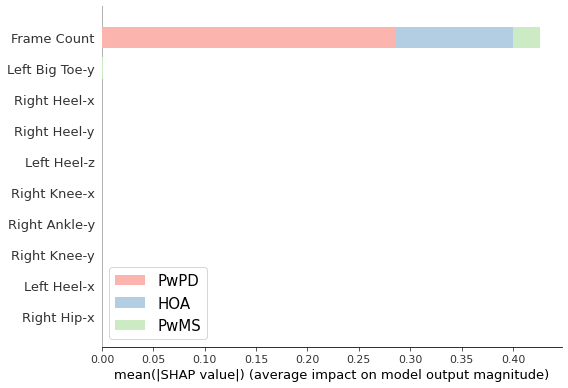

In [17]:
#Global feature importance Bar Plot 
#This has all 3 classes included in a single plot 
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise, features = Xtest_feature_wise_df, plot_type='bar', \
                  class_names= ['HOA', 'PwMS', 'PwPD'], max_display=10, show=False,  color=plt.get_cmap("Pastel1"))
f = plt.gcf()
plt.tight_layout()
plt.legend(fontsize = 15)
#All plots are saved to SHAPResults directory
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_bar.png', dpi = 350)

### Global feature importance Beeswarm plot
### We need 3 different plots for 3 classes in this case 

For HOA


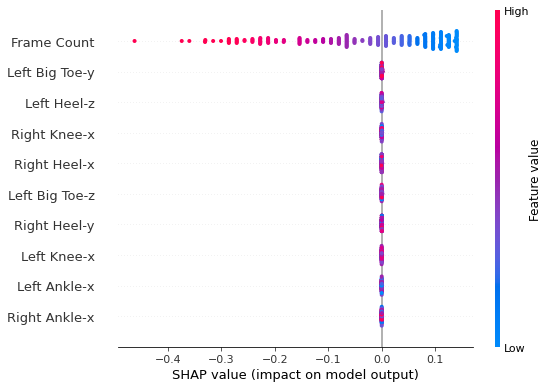

In [18]:
#Global feature importance Beeswarm plot for HOA
print ('For HOA')
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise[0], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_HOA.png', dpi = 350)

For PwMS


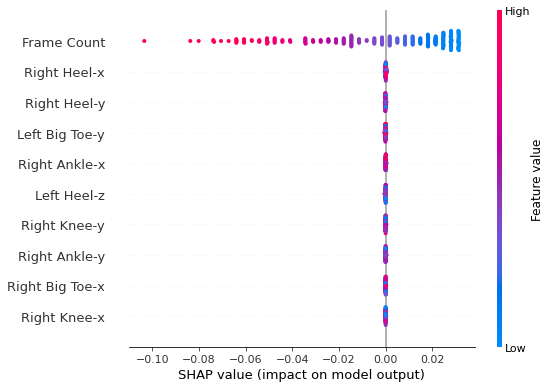

In [19]:
print ('For PwMS')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[1], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_PwMS.png', dpi = 350)

For PwPD


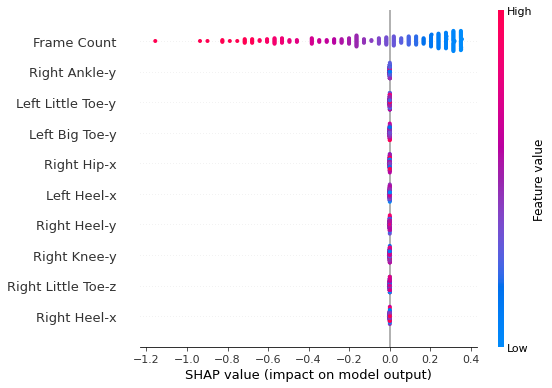

In [20]:
print ('For PwPD')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[2], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_PwPD.png', dpi = 350)

### Global feature importance Violin plot
### We need 3 different plots for 3 classes in this case 

For HOA


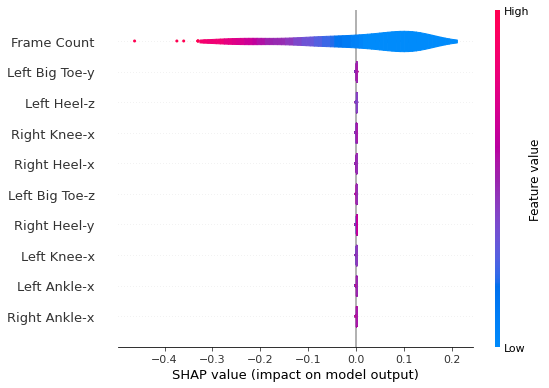

In [21]:
#Global feature importance Violin plot for HOA
print ('For HOA')
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise[0], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_HOA.png', dpi = 350)

For PwMS


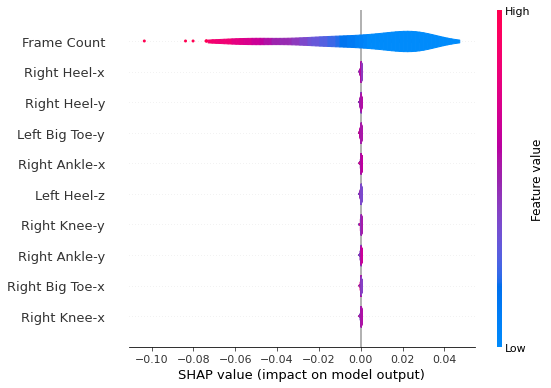

In [22]:
print ('For PwMS')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[1], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_PwMS.png', dpi = 350)

For PwPD


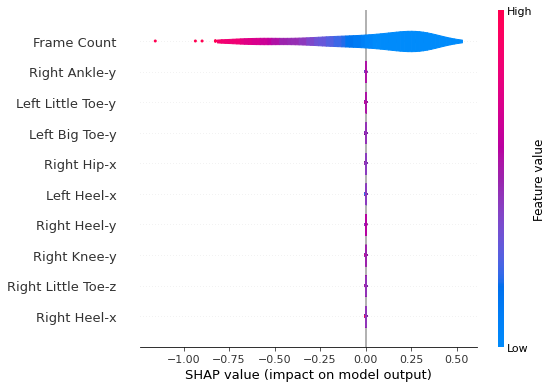

In [23]:
print ('For PwPD')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[2], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_PwPD.png', dpi = 350)

### Local feature importance force plot
### We need 3 different plots for 3 classes in this case and each plot explains a single instance 

In [26]:
#Force plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
class_to_explain = 0 #0 for HOA, 1 for MS, and 2 for PD
out_name = 'HOA'
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])

# plot the explanation of the first prediction
force_ = shap.force_plot(
    base_value=explainer.expected_value[class_to_explain],
    shap_values=shaps_feature_wise[class_to_explain][instance_to_explain],
    features=Xtest_feature_wise_df.iloc[instance_to_explain],
    feature_names=Xtest_feature_wise_df.columns,
    link="identity",
    out_names=out_name
)
#This plot doesn't display but is directly saved at the specified path 
shap.save_html('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
          '/shap_local_force_instance' + str(instance_to_explain) + '_' + out_name + '.htm', force_)

#Display all features and SHAP values
#The table below the plot is the full list of features and their 
#SHAP additive weights.
display(pd.DataFrame(data=shaps_feature_wise[class_to_explain][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[instance_to_explain]).transpose().sort_values(by=instance_to_explain, ascending=True))

Expected values:  [-0.2810705   0.16539077 -1.4333426 ]
True label:  tensor(2)


,0
Frame Count,-0.212492
Left Ankle-y,-0.000346
Left Knee-y,-0.000192
Right Little Toe-z,-0.000191
Right Big Toe-y,-0.000179
Right Heel-y,-0.000164
Left Hip-z,-0.000164
Right Little Toe-y,-0.000144
Right Ankle-z,-0.000093
Right Ankle-y,-0.000070


### Local feature importance decision plot
### We need 3 different plots for 3 classes in this case and each plot explains a single instance only

Expected values:  [-0.2810705   0.16539077 -1.4333426 ]
True label:  tensor(2)


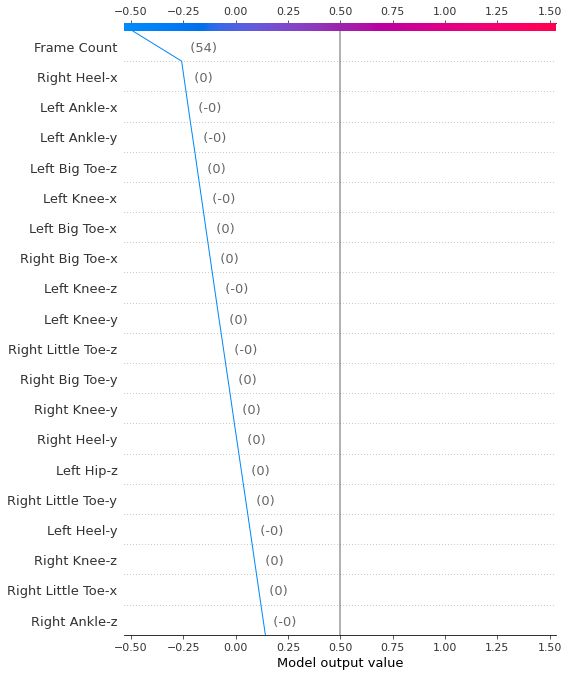

In [25]:
##Decision plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
class_to_explain = 0 #0 for HOA, 1 for MS, and 2 for PD
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])

# We provide new_base_value as the cutoff probability for the classification mode
# This is done to increase the interpretability of the plot 
new_base_value=0.5

# plot the explanation of the first prediction
shap.decision_plot(
    base_value=explainer.expected_value[class_to_explain],
    shap_values=shaps_feature_wise[class_to_explain][instance_to_explain],
    features=Xtest_feature_wise_df.iloc[instance_to_explain],
    feature_names=Xtest_feature_wise_df.columns.to_list(),
    link="identity",
    new_base_value=0.5,
    show = False
)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
          '/shap_local_decision_instance' + str(instance_to_explain) + '_' + out_name + '.png', dpi = 350)